1. [5, 10, 15, 20] auc-roc increase
 

Steps:
1. load best model for moleformer, smiles-bert, chemberta;
2. load [5, 10, 15, 20] dataset;
3. run experiments on different setting, and obtain the auc-roc value for each setting;
4. draw the figure of the auc-roc.

In [ ]:
import numpy as np
import pandas as pd 

import torch 
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, precision_recall_curve

import os

In [ ]:
base_path = 'tc-hard/dataset/few_shot_split/pep+cdr3b'

DATA_PATH = "tc-hard/dataset/few_shot_split/pep+cdr3b"

DICT_PATH = "TCRPrediction/tc-hard/meta_data"

negative_generate_mode = "only-sampled-negs"
# negative_generate_mode = "only-neg-assays"
model_name = "moleformer"
# model_name = "ChemBERTa"


configs = {
   "only-neg-assays": {
      "moleformer":{
         "best_model_path": "vibtcr/data/result/NAbest",
         "input_size": 480 + 768,
         "hidden_sizes": [32],
         "dropout": 0.3,
         "learning_rate": 0.001,
      },
      "Smiles-Bert":{
         "best_model_path": "tc-hard/embeddings/SMILES_BERT/only-neg-assays",
         "input_size": 480 + 768,
         "hidden_sizes": [64, 32, 16],
         "dropout":0.1,
         "learning_rate": 0.01,
      },
      "ChemBERTa":{
         "best_model_path": "results/HF_CH/NA/1",
         "input_size": 480 + 384,
         "hidden_sizes": [32],
         "dropout": 0.3,
         "learning_rate": 0.001,
      },
   },
   "only-sampled-negs": {
      "moleformer":{
         "best_model_path": "results/HF_ME/RN/5",
         "input_size": 480 + 768,
         "hidden_sizes": [512,256,128,64,32],
         "dropout": 0.3,
         "learning_rate": 0.01,
      },
      "Smiles-Bert":{
         "best_model_path": "tc-hard/embeddings/SMILES_BERT/only-sampled-negs",
         "input_size": 480 + 768,
         "hidden_sizes": [64, 32, 16],
         "dropout":0.1,
         "learning_rate": 0.01,
      },
      "ChemBERTa":{
         "best_model_path": "results/HF_CH/RN/1",
         "input_size": 480 + 384,
         "hidden_sizes": [512,256,128,64,32],
         "dropout": 0.3,
         "learning_rate": 0.01,
      },
   },
}

config = configs[negative_generate_mode][model_name]

In [3]:
def make_df(df_path):
    df = pd.read_csv(df_path)

    df['tcrb'] = df['tcrb'].str.replace('O','X')
    df['peptide'] = df['peptide'].str.replace('O','X')

    return df

In [4]:
import pickle

with open(os.path.join(DICT_PATH, model_name, negative_generate_mode, "peptide_dict.pkl"), 'rb') as f:
    peptide_embed_dict = pickle.load(f)

with open(os.path.join(DICT_PATH, model_name, negative_generate_mode, "tcrb_dict.pkl"), 'rb') as f:
    tcrb_embed_dict = pickle.load(f)

In [5]:
def get_embeddings(train_df, validation_df, test_df):
    tcrb_seq_train = np.vstack(train_df['tcrb'].apply(lambda x: tcrb_embed_dict[x]).values)
    tcrb_seq_validation = np.vstack(validation_df['tcrb'].apply(lambda x: tcrb_embed_dict[x]).values)
    tcrb_seq_test = np.vstack(test_df['tcrb'].apply(lambda x: tcrb_embed_dict[x]).values)

    peptide_seq_train = np.vstack(train_df['peptide'].apply(lambda x: peptide_embed_dict[x]).values)
    peptide_seq_validation = np.vstack(validation_df['peptide'].apply(lambda x: peptide_embed_dict[x]).values)
    peptide_seq_test = np.vstack(test_df['peptide'].apply(lambda x: peptide_embed_dict[x]).values)

    label_seq_train = train_df['label'].values
    label_seq_validation = validation_df['label'].values
    label_seq_test = test_df['label'].values

    
    if model_name in ["moleformer", "ChemBERTa"]:
        X_train = np.column_stack((peptide_seq_train, tcrb_seq_train))
        X_validation = np.column_stack((peptide_seq_validation, tcrb_seq_validation))
        X_test = np.column_stack((peptide_seq_test, tcrb_seq_test))
    elif model_name in ["Smiles-Bert"]:
        X_train = np.column_stack((tcrb_seq_train, peptide_seq_train))
        X_validation = np.column_stack((tcrb_seq_validation, peptide_seq_validation))
        X_test = np.column_stack((tcrb_seq_test, peptide_seq_test))
    else:
        raise ValueError("Invalid model name")

    y_train = label_seq_train

    y_validation = label_seq_validation
    
    y_test = label_seq_test

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [6]:
# load model
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[512, 512, 512, 256, 256, 256], dropout=0.2):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.dropout = dropout

        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [7]:
def evaluate_and_save(num_few_shot, dataset_index, load_path):
    
    train_df_path = os.path.join(DATA_PATH, "train", negative_generate_mode, f"{num_few_shot}-train-{dataset_index}.csv")
    validation_df_path = os.path.join(DATA_PATH, "validation", negative_generate_mode, f"{num_few_shot}-validation-{dataset_index}.csv")
    test_df_path = os.path.join(DATA_PATH, "test", negative_generate_mode, f"{num_few_shot}-test-{dataset_index}.csv")

    train_df = make_df(train_df_path)
    validation_df = make_df(validation_df_path)
    test_df = make_df(test_df_path)

    print("loading data")
    X_train, y_train, X_validation, y_validation, X_test, y_test = get_embeddings(train_df, validation_df, test_df)
    print("getting embeddings")
    
    model = MLP(input_size = config["input_size"], output_size = 2, hidden_sizes = config["hidden_sizes"], dropout = config["dropout"])
    # This path is the further trained best model path
    model.load_state_dict(torch.load(os.path.join(load_path, f"best_{dataset_index}.pth")))
    model.to("cuda:0")
    model.eval()
    # with torch.no_grad():
    #     test_probabilities = []
        # y_true_test = []
        # test_running_loss = 0.0
        # for test_inputs, test_targets in test_loader:
        #     test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
        #     test_outputs = model(test_inputs.float())
        #     test_loss = criterion(test_outputs, test_targets)
        #     test_running_loss += test_loss.item() * test_inputs.size(0)
        #     test_probabilities.extend(torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy())
            # y_true_test.extend(test_targets.cpu().numpy())

    y_pred = model(torch.from_numpy(X_test).to("cuda:0"))
    test_probabilities = torch.softmax(y_pred, dim=1)[:, 1].detach().cpu().numpy()
    y_true_test = y_test
    # test_loss = test_running_loss / len(test_loader.dataset)    
    test_auc = roc_auc_score(y_true_test, test_probabilities)    
    test_predictions = [1 if prob > 0.5 else 0 for prob in test_probabilities]
    precision, recall, _ = precision_recall_curve(y_true_test, test_probabilities)
    
    metrics = {
            'AUROC': test_auc,
            'Accuracy': accuracy_score(y_true_test, test_predictions),
            'Recall': recall_score(y_true_test, test_predictions),
            'Precision': precision_score(y_true_test, test_predictions),
            'F1 score': f1_score(y_true_test, test_predictions),
            'AUPR': auc(recall, precision),
        }

    result_df = pd.DataFrame({
            'score': list(metrics.values()),
            'metrics': list(metrics.keys()),
            'experiment': dataset_index
        })
    
    print(f"\nBest Model Performance and Evaluation of dataset{dataset_index}:")
    for metric, score in metrics.items():
        print(f"{metric}: {score*100:.4f}%")

    return result_df

In [8]:
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
batch_size = 32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [9]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, scheduler, device, dataset_index, output_model_path):
    patience = 20
    counter = 0
    best_val_roc_auc = 0.0
    best_model_path = output_model_path + f"/best_{dataset_index}.pth"
    
    print(f"Training model for dataset {dataset_index}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)  
        model.eval()
        val_running_loss = 0.0
        y_true_val = []
        val_probabilities = [] 
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs.float())
                val_loss = criterion(val_outputs, val_targets)
                val_running_loss += val_loss.item() * val_inputs.size(0)       
                val_probabilities.extend(torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy())
                y_true_val.extend(val_targets.cpu().numpy())  
            val_loss = val_running_loss / len(val_loader.dataset)
            val_auc = roc_auc_score(y_true_val, val_probabilities)
            precision, recall, _ = precision_recall_curve(y_true_val, val_probabilities)
            pr_auc = auc(recall, precision)

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation AUC: {val_auc:.4f}, PR-AUC: {pr_auc:.4f}')

        if val_auc > best_val_roc_auc:
            best_val_roc_auc = val_auc
            torch.save(model.state_dict(), best_model_path)
            print("Saved best model")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch}.')
                break        
        scheduler.step(val_auc)
    print("Training complete. Best Val ROC-AUC: {:.4f}".format(best_val_roc_auc))  

    return best_model_path

In [10]:
# model = MLP(input_size = 480 + 768, output_size = 2, hidden_sizes = [512,256,128,64,32], dropout = 0.3)
# model.load_state_dict(torch.load(os.path.join("/project/zhiwei/hf78/vibtcr/data/result/RNbest", f"best_mol-esm_2.pth")))

In [ ]:
for num_few_shot in [1, 2, 3, 4, 5, 10, 15]:
    output_model_path = f"analysis/few-shot/{model_name}/{negative_generate_mode}/{num_few_shot}"
    
    if not os.path.exists(output_model_path):
        os.makedirs(output_model_path)

    for dataset_index in range(5):
        print("loading model")
        model = MLP(input_size = config["input_size"], output_size = 2, hidden_sizes = config["hidden_sizes"], dropout = config["dropout"])
        model.load_state_dict(torch.load(os.path.join(config["best_model_path"], f"best_mol-esm_{dataset_index}.pth")))
        model = model.to("cuda:0")

        train_df_path = os.path.join(DATA_PATH, "train", negative_generate_mode, f"{num_few_shot}-train-{dataset_index}.csv")
        validation_df_path = os.path.join(DATA_PATH, "validation", negative_generate_mode, f"{num_few_shot}-validation-{dataset_index}.csv")
        test_df_path = os.path.join(DATA_PATH, "test", negative_generate_mode, f"{num_few_shot}-test-{dataset_index}.csv")

        train_df = make_df(train_df_path)
        validation_df = make_df(validation_df_path)
        test_df = make_df(test_df_path)

        print("loading data")
        X_train, y_train, X_validation, y_validation, X_test, y_test = get_embeddings(train_df, validation_df, test_df)
        print("getting embeddings")

        train_dataset = TensorDataset(torch.from_numpy(X_train), torch.tensor(y_train))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dataset = TensorDataset(torch.from_numpy(X_validation), torch.tensor(y_validation))
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_dataset = TensorDataset(torch.from_numpy(X_test), torch.tensor(y_test))
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    
        
        optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9, weight_decay=0.001)  
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
        
        train_model(model, train_loader, val_loader, 10, criterion, optimizer, scheduler, device, dataset_index, output_model_path)

loading model
loading data
getting embeddings
Training model for dataset 0
Epoch [1/10], Validation Loss: 0.6455, Validation AUC: 0.4917, PR-AUC: 0.3370
Saved best model
Epoch [2/10], Validation Loss: 0.6501, Validation AUC: 0.4609, PR-AUC: 0.3244
Epoch [3/10], Validation Loss: 0.6504, Validation AUC: 0.4546, PR-AUC: 0.3133
Epoch [4/10], Validation Loss: 0.6484, Validation AUC: 0.4739, PR-AUC: 0.3328
Epoch [5/10], Validation Loss: 0.6460, Validation AUC: 0.4884, PR-AUC: 0.3397
Epoch [6/10], Validation Loss: 0.6452, Validation AUC: 0.4985, PR-AUC: 0.3427
Saved best model
Epoch [7/10], Validation Loss: 0.6448, Validation AUC: 0.4891, PR-AUC: 0.3365
Epoch [8/10], Validation Loss: 0.6524, Validation AUC: 0.4472, PR-AUC: 0.3125
Epoch [9/10], Validation Loss: 0.6423, Validation AUC: 0.5315, PR-AUC: 0.3558
Saved best model
Epoch [10/10], Validation Loss: 0.6441, Validation AUC: 0.4870, PR-AUC: 0.3387
Training complete. Best Val ROC-AUC: 0.5315
loading model
loading data
getting embeddings
Tra

In [ ]:
result_df = pd.DataFrame({
    "score": [],
    "metrics": [],
    "experiment": [] 
})
l = []
auroc_list = []
for num_few_shot in [1, 2, 3, 4, 5, 10, 15]:
    output_model_path = f"analysis/few-shot/{model_name}/{negative_generate_mode}/{num_few_shot}"
    for dataset_index in range(5):
        
        l.append(evaluate_and_save(num_few_shot, dataset_index, output_model_path))

    result_df = pd.concat(l)
    # print(result_df)
    result_df.to_csv(f"few-shot-result/{model_name}/{negative_generate_mode}/{num_few_shot}_result.csv")
    
    stats = result_df.groupby('metrics')['score'].agg(['mean', 'std']).reset_index()
    stats.to_csv(f"few-shot-result/{model_name}/{negative_generate_mode}/{num_few_shot}_stats.csv")
    
    mean = stats[stats['metrics'] == 'AUROC']['mean'].values[0]
    std = auroc_std = stats[stats['metrics'] == 'AUROC']['std'].values[0]
    
    auroc_list.append((mean, std))

auroc_list

loading data
getting embeddings


/project/zhiwei/cq5/miniconda3/envs/Protein/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Model Performance and Evaluation of dataset0:
AUROC: 51.5577%
Accuracy: 66.7206%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 32.9493%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset1:
AUROC: 52.4453%
Accuracy: 65.3487%
Recall: 0.5279%
Precision: 17.6090%
F1 score: 1.0250%
AUPR: 34.7044%
loading data
getting embeddings


/project/zhiwei/cq5/miniconda3/envs/Protein/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Model Performance and Evaluation of dataset2:
AUROC: 52.0052%
Accuracy: 65.6373%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 35.4853%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset3:
AUROC: 49.2590%
Accuracy: 65.5133%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 32.9264%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset4:
AUROC: 51.6945%
Accuracy: 65.9820%
Recall: 0.4220%
Precision: 38.8393%
F1 score: 0.8349%
AUPR: 34.7870%
loading data
getting embeddings


/project/zhiwei/cq5/miniconda3/envs/Protein/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Model Performance and Evaluation of dataset0:
AUROC: 49.7195%
Accuracy: 66.7189%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 32.3447%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset1:
AUROC: 51.6673%
Accuracy: 66.0005%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 34.7651%
loading data
getting embeddings


/project/zhiwei/cq5/miniconda3/envs/Protein/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Model Performance and Evaluation of dataset2:
AUROC: 50.8790%
Accuracy: 65.6377%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 34.8428%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset3:
AUROC: 50.0421%
Accuracy: 65.5353%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 33.5866%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset4:
AUROC: 52.6923%
Accuracy: 66.0318%
Recall: 0.2765%
Precision: 42.5373%
F1 score: 0.5494%
AUPR: 35.4609%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset0:
AUROC: 52.2517%
Accuracy: 66.7107%
Recall: 0.0050%
Precision: 16.6667%
F1 score: 0.0099%
AUPR: 33.9825%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset1:
AUROC: 49.1334%
Accuracy: 65.9773%
Recall: 0.0048%
Precision: 5.2632%
F1 score: 0.0097%
AUPR: 32.3518%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset2:
AUROC: 51.2

/project/zhiwei/cq5/miniconda3/envs/Protein/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Model Performance and Evaluation of dataset2:
AUROC: 52.2492%
Accuracy: 65.6386%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 35.4296%
loading data
getting embeddings


/project/zhiwei/cq5/miniconda3/envs/Protein/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Model Performance and Evaluation of dataset3:
AUROC: 50.0740%
Accuracy: 65.5511%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 33.8689%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset4:
AUROC: 52.0614%
Accuracy: 66.0542%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 34.5739%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset0:
AUROC: 52.1113%
Accuracy: 66.7189%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 34.2372%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset1:
AUROC: 52.5268%
Accuracy: 65.6413%
Recall: 0.4263%
Precision: 22.2222%
F1 score: 0.8365%
AUPR: 34.8870%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset2:
AUROC: 52.3293%
Accuracy: 65.6042%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 35.2064%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset3:
AUROC: 49.86

/project/zhiwei/cq5/miniconda3/envs/Protein/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Model Performance and Evaluation of dataset1:
AUROC: 51.2970%
Accuracy: 66.0016%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 34.4434%
loading data
getting embeddings


/project/zhiwei/cq5/miniconda3/envs/Protein/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Best Model Performance and Evaluation of dataset2:
AUROC: 50.8202%
Accuracy: 65.6413%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 34.5104%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset3:
AUROC: 48.6792%
Accuracy: 65.4066%
Recall: 0.1393%
Precision: 20.0000%
F1 score: 0.2766%
AUPR: 33.3894%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset4:
AUROC: 51.6279%
Accuracy: 65.9716%
Recall: 0.0582%
Precision: 15.3846%
F1 score: 0.1160%
AUPR: 34.5088%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset0:
AUROC: 49.9102%
Accuracy: 66.7124%
Recall: 0.0000%
Precision: 0.0000%
F1 score: 0.0000%
AUPR: 32.3471%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset1:
AUROC: 52.5342%
Accuracy: 65.9980%
Recall: 0.0097%
Precision: 33.3333%
F1 score: 0.0194%
AUPR: 34.8707%
loading data
getting embeddings

Best Model Performance and Evaluation of dataset2:
AUROC: 51.

[(0.5139234879718076, 0.012403621154522837),
 (0.5119619643837281, 0.01174719796575954),
 (0.510299460035251, 0.011537766681599396),
 (0.5110788319862352, 0.010921236736234857),
 (0.5123866676465489, 0.011003368361325717),
 (0.5114843613188391, 0.011099187023518746),
 (0.5113341235379829, 0.010765304859695608)]

0: 0.57

20% seen

1: 0.589

2: 0.602

3: 0.613

4: 0.625

5: 0.631

10: 0.635

15: 0.642

20: 0.634

100: 0.648

150: 0.640

200: 0.637

300: 0.630

In [13]:
auroc_list = np.array(auroc_list)
auroc_list[:, 0]

array([0.51392349, 0.51196196, 0.51029946, 0.51107883, 0.51238667,
       0.51148436, 0.51133412])

RN:
- moleformer: [0.57, 0.589, 0.602, 0.613, 0.625, 0.631, 0.635, 0.642]

- ChemBERTa: [0.51906293, 0.52133025, 0.52302746, 0.5257971 , 0.52503283, 0.52559256, 0.52588146, 0.52637891]


NA:
- moleformer: [0.901, 0.924796, 0.931580, 0.944642, 0.947340, 0.948553, 0.950311, 0.955772]

- ChemBERTa: [0.7314, 0.83712974, 0.84530559, 0.86038455, 0.87013616, 0.86963808, 0.85947473, 0.85686629]

/home/cong/anaconda3/envs/Protein/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cong/anaconda3/envs/Protein/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cong/anaconda3/envs/Protein/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cong/anaconda3/envs/Protein/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

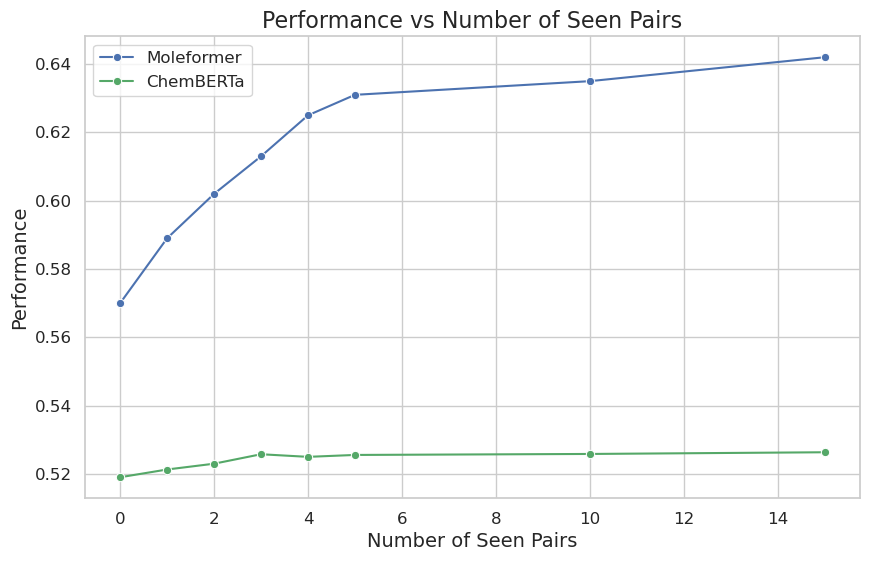

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_seen_pairs = [0, 1, 2, 3, 4, 5, 10, 15]
performance_Moleformer = [0.57, 0.589, 0.602, 0.613, 0.625, 0.631, 0.635, 0.642]
performance_ChemBERTa = [0.51906293, 0.52133025, 0.52302746, 0.5257971 , 0.52503283, 0.52559256, 0.52588146, 0.52637891]


sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
sns.lineplot(x=num_seen_pairs, y=performance_Moleformer, marker='o', color='b', label='TIDE')
sns.lineplot(x=num_seen_pairs, y=performance_ChemBERTa, marker='o', color='g', label='ChemBERTa')

# Adding titles and labels
plt.title('Performance vs Number of Seen Pairs', fontsize=16)
plt.xlabel('Number of Seen Pairs', fontsize=14)
plt.ylabel('Performance', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

0: 0.901

20% seen

1: 0.924796

2: 0.948553

3: 0.947340

4: 0.944642

5: 0.907792 / 0.931580

10: 0.907764 / 0.933113

15: 0.907747 / 0.929772

20: 0.907721 / 0.956605

100: 0.907400 / 0.945554

150: 0.907151 / 0.952375

200: 0.906876 / 0.952898

300: 0.904357 / 0.956077

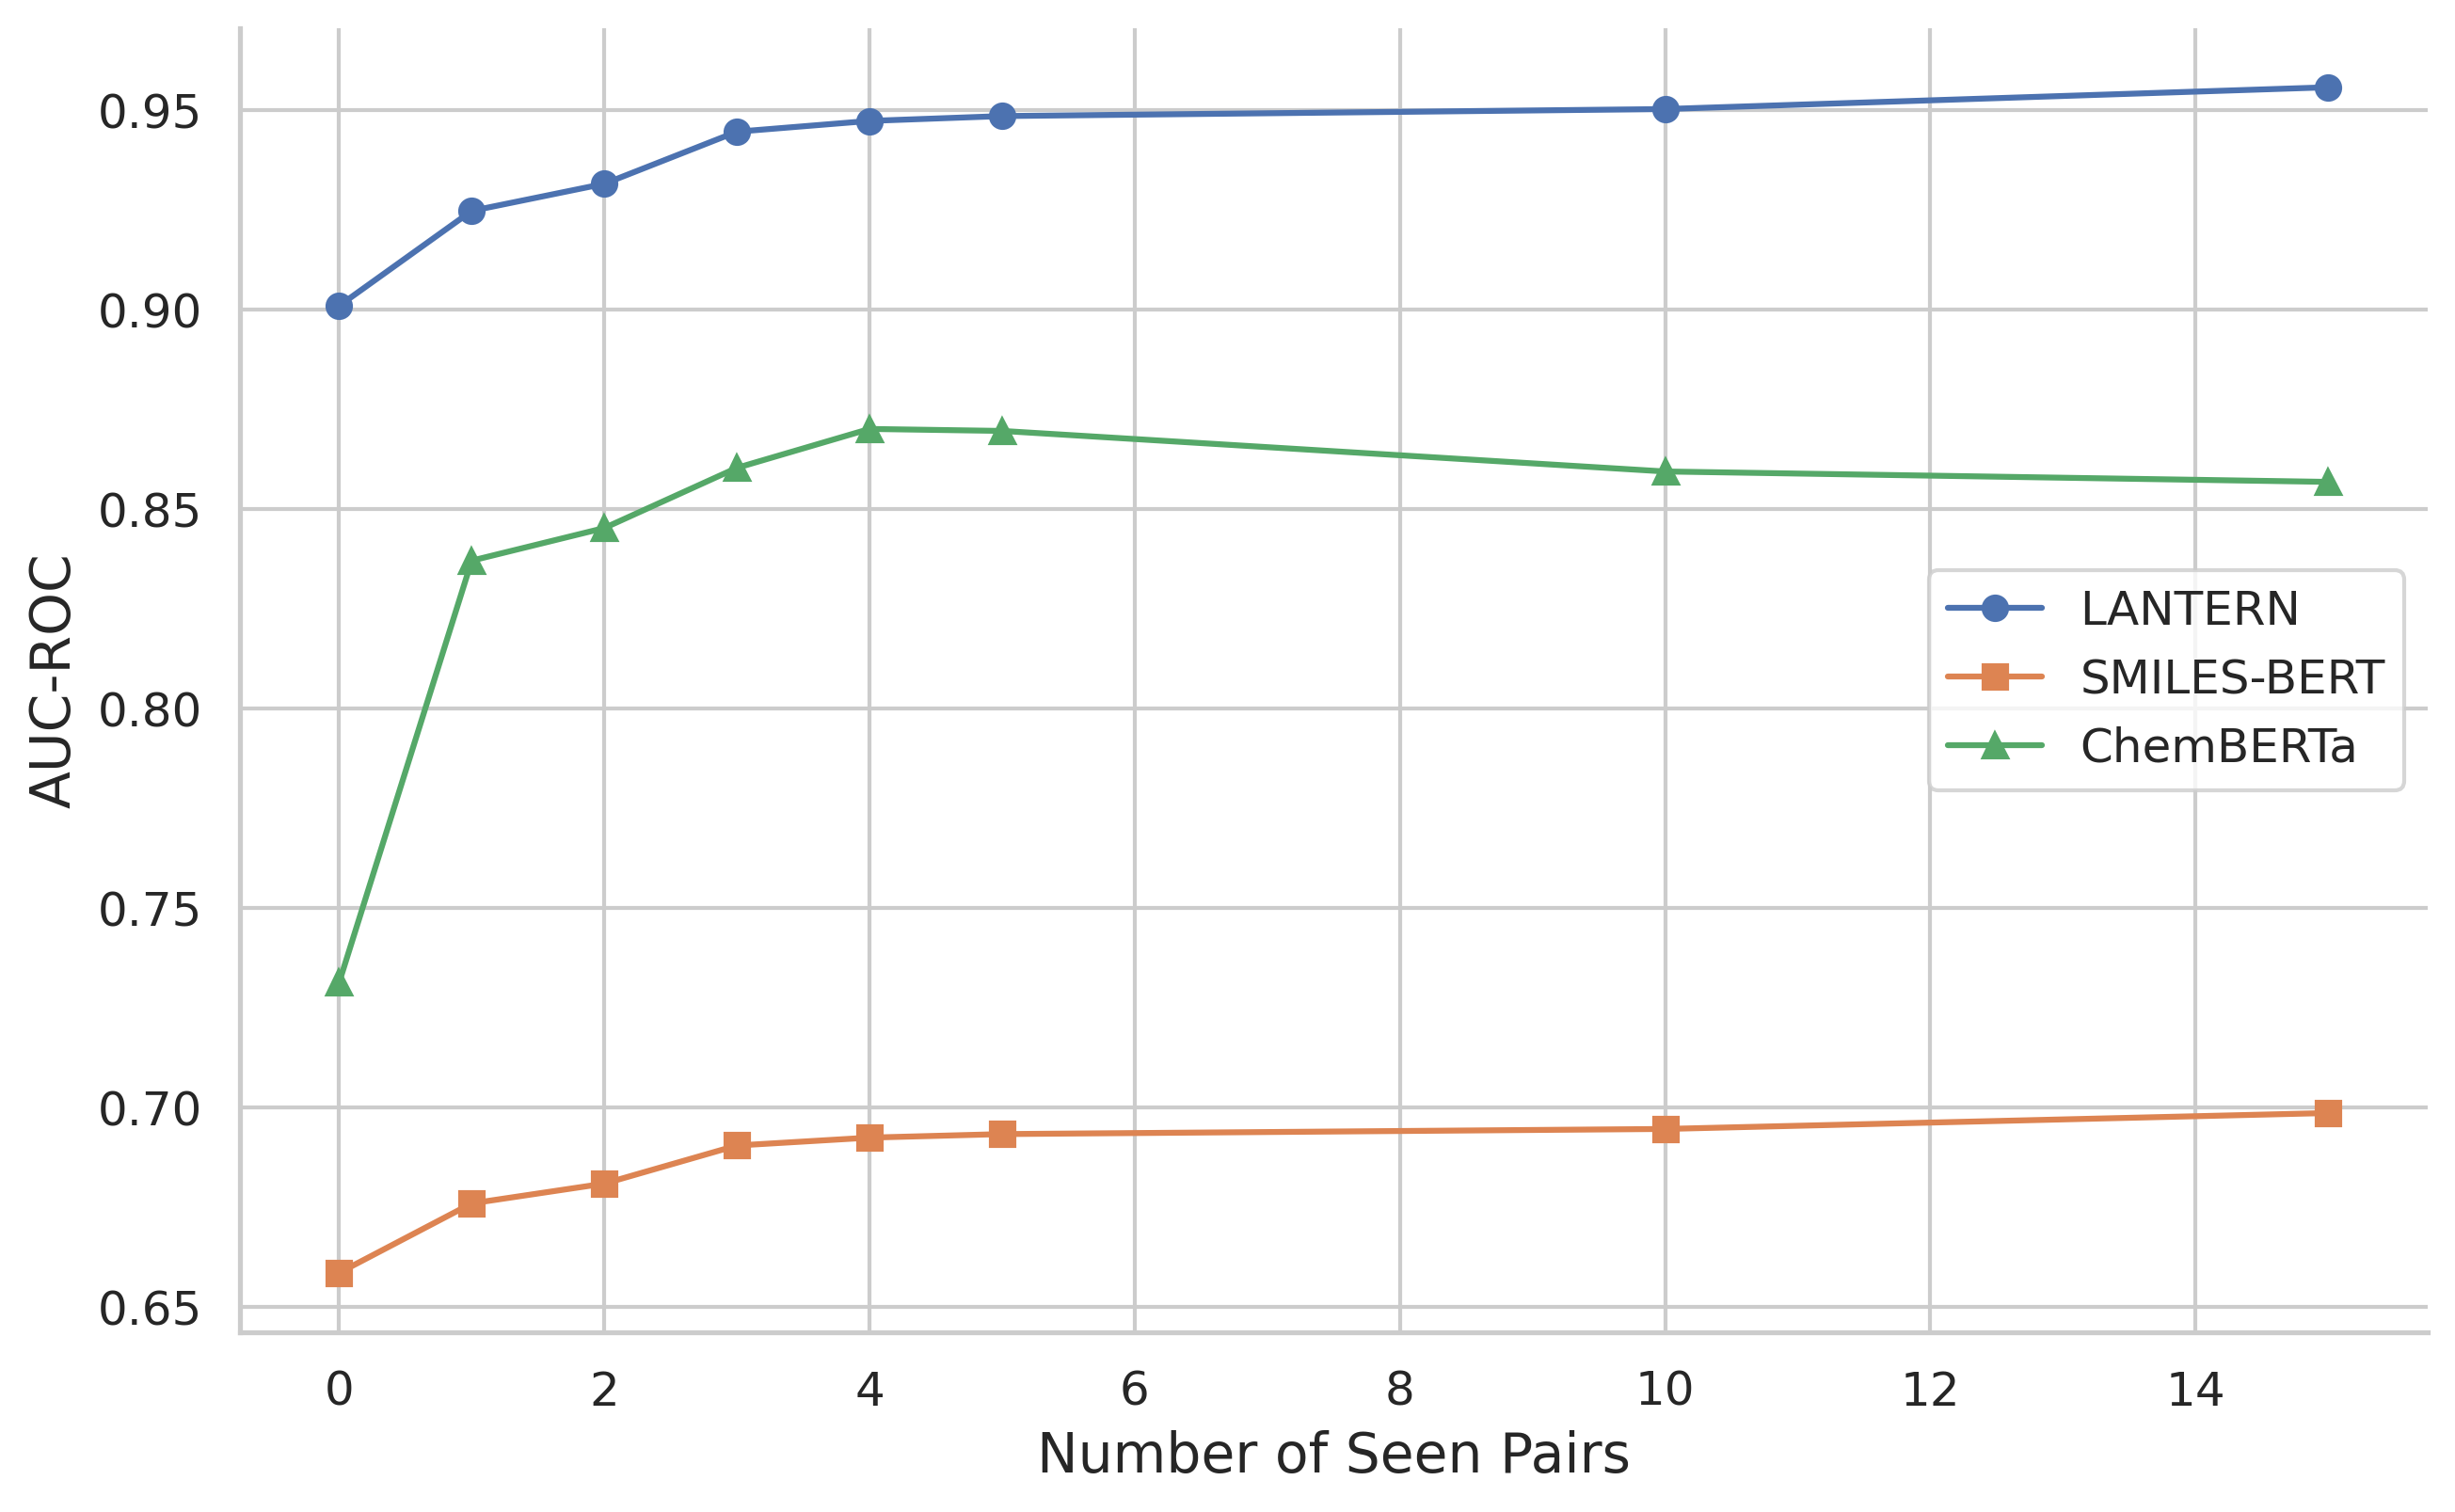

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
num_seen_pairs = [0, 1, 2, 3, 4, 5, 10, 15]
performance_Moleformer = [0.901, 0.924796, 0.931580, 0.944642, 0.947340, 0.948553, 0.950311, 0.955772]
performance_Smiles_Bert = [0.658637, 0.6760320344639289, 0.6809911836403995, 0.6905395926237513, 0.692511848590455, 0.6933985596681465, 0.6946836693751387, 0.6986756967413984]
performance_ChemBERTa = [0.7314, 0.83712974, 0.84530559, 0.86038455, 0.87013616, 0.86963808, 0.85947473, 0.85686629]


plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(num_seen_pairs, performance_Moleformer, marker='o', label='TIDE')
plt.plot(num_seen_pairs, performance_Smiles_Bert, marker='s', label='SMILES-BERT')
plt.plot(num_seen_pairs, performance_ChemBERTa, marker='^', label='ChemBERTa')

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.ylabel('AUC-ROC')

plt.grid(True)

plt.xlabel('Number of Seen Pairs', fontsize=14)
plt.ylabel('AUC-ROC', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()